In [36]:
import json
import pandas  as pd
import geopandas as gpd
from shapely.geometry import MultiLineString
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import folium
import branca.colormap as cm

### Converting json file to dataframe

In [5]:
# Reading Json file with contour data

with open("intensity_data.json") as read_file:
    intensity_data = json.load(read_file)

print(type(intensity_data))

<class 'dict'>


In [6]:
# Looking at keys in the json file
intensity_data.keys()

dict_keys(['type', 'crs', 'features', 'metadata', 'bbox'])

In [7]:
# Extracting the features
features = intensity_data["features"]

geometries = []
values = []
colors = []
weights = []

# Extracting features from json file into multiple list

for feature in features:
    coordinates = feature['geometry']['coordinates']
    properties = feature['properties']

    # Saving as multiline string 
    multiline = MultiLineString(coordinates)
    geometries.append(multiline)

    # Saving as list
    values.append(properties['value'])
    colors.append(properties['color'])
    weights.append(properties['weight'])

In [9]:
# Making a geo-dataframe from the lists

gdf = gpd.GeoDataFrame({
    'geometry' : geometries,
    'value' : values,
    'color' : colors,
    'weight' : weights
    },
    crs="EPSG:4326"   
)
gdf.head()

geometry  value    color  weight
0  MULTILINESTRING ((89.65848 31.95, 89.66605 31....    3.0  #a0e5ff       2
1  MULTILINESTRING ((80.85 29.4914, 80.88591 29.5...    3.5  #90f2ff       4
2  MULTILINESTRING ((80.85 26.97175, 80.89991 26....    4.0  #80ffff       2
3  MULTILINESTRING ((85.29202 25.26354, 85.05911 ...    4.5  #7cffc7       4
4  MULTILINESTRING ((85.12566 25.57628, 85.05911 ...    5.0  #7cff90       2

In [12]:
# Reading the ward latitude and longitude into a dataframe
# We need to predict the intensities at these locations.
df_ward_lat_lon = pd.read_csv("ward_id_and_lat_lon_mapping.csv")
df_ward_lat_lon.head()

ward_id   latitude  longitude
0   120101  27.275716  86.275134
1   120102  27.261992  86.235941
2   120103  27.300831  86.275827
3   120104  27.310806  86.345178
4   120105  27.293568  86.327860

In [13]:
# Function to extractpoints from the multistring

def extract_points_from_multistring(geometry):
    points = []
    if geometry.geom_type == 'MultiLineString':
        for line in geometry.geoms:
            points.extend(list(line.coords))
    return points

# Extracting each point and their intensity values 
all_points = []
all_values = []

for idx, row in gdf.iterrows():
    contour_points = extract_points_from_multistring(row['geometry'])
    all_points.extend(contour_points)
    all_values.extend([row['value']]*len(contour_points))

# Extracting lattitude and longitude seperately from all points

all_lat = []
all_lng = []
for lat_lon in all_points:
    all_lat.append(lat_lon[1])
    all_lng.append(lat_lon[0])

In [14]:

df_contour = pd.DataFrame([all_lat,all_lng,all_values]).transpose()
df_contour.columns = ["latitude","longitude","intensity"]
df_contour.head()

latitude  longitude  intensity
0  31.950000  89.658480        3.0
1  31.866841  89.666054        3.0
2  31.847690  89.684140        3.0
3  31.820714  89.783961        3.0
4  31.683890  89.890925        3.0

### Visualizing the contour data

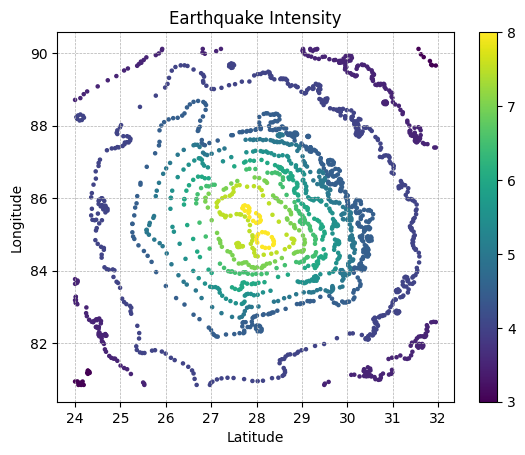

In [19]:
scatter = plt.scatter(df_contour["latitude"], df_contour["longitude"], c=df_contour["intensity"], s=5)
plt.colorbar(scatter)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Earthquake Intensity");

In [40]:
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'red'], 
                             vmin=df_contour["intensity"].min(), 
                             vmax=df_contour["intensity"].max())
colormap.caption = 'Intensity'

In [42]:
m = folium.Map(location=[df_contour["latitude"].mean(), df_contour["longitude"].mean()], zoom_start=6)

# Add CircleMarkers with gradient colors
for lat, lon, value in zip(df_contour["latitude"], df_contour["longitude"], df_contour["intensity"]):
    folium.CircleMarker(
        location=(lat, lon),
        radius=4,  # Adjust the radius based on your needs
        color=colormap(value),  # Use the colormap for the color
        fill=True,
        fill_color=colormap(value),
        fill_opacity=0.6,
        popup=f'Intensity: {value}'
    ).add_to(m)

# Add the colormap to the map (as a legend)
colormap.add_to(m)

# Save the map to an HTML file
m.save('map.html')

# Display the map if you're using a Jupyter Notebook
m

### Interpolating the values


In [43]:
latitudes = np.array(df_contour['latitude'])
longitudes = np.array(df_contour['longitude'])
intensities = np.array(df_contour['intensity'])

new_latitudes = np.array(df_ward_lat_lon['latitude'])
new_longitudes = np.array(df_ward_lat_lon['longitude'])

new_points = np.column_stack((new_latitudes,new_longitudes))

existing_points = np.column_stack((latitudes,longitudes))



In [44]:
interpolated_intensities = griddata(existing_points,intensities,new_points,method='linear')

df_ward_lat_lon["pred_intensity"] = interpolated_intensities

df_ward_lat_lon.head()


ward_id   latitude  longitude  pred_intensity
0   120101  27.275716  86.275134        6.928824
1   120102  27.261992  86.235941        6.986425
2   120103  27.300831  86.275827        6.960487
3   120104  27.310806  86.345178        6.881559
4   120105  27.293568  86.327860        6.878566

### Visualizing the interpolated intensities

In [45]:
m = folium.Map(location=[df_ward_lat_lon["latitude"].mean(), df_ward_lat_lon["longitude"].mean()], zoom_start=6)

# Add CircleMarkers with gradient colors
for lat, lon, value in zip(df_ward_lat_lon["latitude"], df_ward_lat_lon["longitude"], df_ward_lat_lon["pred_intensity"]):
    folium.CircleMarker(
        location=(lat, lon),
        radius=4,  # Adjust the radius based on your needs
        color=colormap(value),  # Use the colormap for the color
        fill=True,
        fill_color=colormap(value),
        fill_opacity=0.6,
        popup=f'pred_intensity: {value}'
    ).add_to(m)

# Add the colormap to the map (as a legend)
colormap.add_to(m)

# Save the map to an HTML file
m.save('map.html')

# Display the map if you're using a Jupyter Notebook
m

In [18]:
#Exporting the ward intensity data frame
df_ward_lat_lon.to_csv("ward_level_pred_intensity.csv",index=False)